# Redes Neuronales (solo con numpy)

In [1]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['figure.dpi']=300

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

## Funciones

In [2]:
def apply_layer(y_in,w,b,activation):
    """
    Calcula el paso de una capa a la siguiente, dados
    una matriz de pesos w (tamano [n_neurons_in,n_neurons_out])
    un vector bias b (longitud n_neurons_out)
    y los valores de la neurona de entrada y_in 
    (tamano [batchsize,n_neurons_in])
    
    retorna los valores de las neuronas de salida en la siguiente capa
    (tamano [batchsize, n_neurons_out])
    """
    z=np.dot(y_in, w) + b # proceso en lote: y_in es de tamano [batchsize,num_neurons_in]

    if activation=='sigmoid':
        return(1/(1 + np.exp(-z)))
    elif activation=='jump':
        return(np.array(z>0, dtype='float'))
    elif activation=='linear':
        return(z)
    elif activation=='reLU':
        return((z>0)*z)

In [3]:
def apply_net(y_in,weights,biases,activations):
    """
    Aplica toda una red neuronal de multiples capas
    """
    y = y_in
    for j in range(len(biases)):
        y = apply_layer(y, weights[j], biases[j], activations[j])
    return(y)

In [4]:
# algunas rutinas internas para hacer el plot de la red
def plot_connection_line(ax, X, Y, W, vmax = 1.0, linewidth = 3):
    t = np.linspace(0, 1, 20)
    if W>0:
        col=[0, 0.4, 0.8]
    else:
        col=[1, 0.3, 0]
    ax.plot(X[0] + (3*t**2 - 2*t**3)*(X[1] - X[0]), Y[0] + t*(Y[1] - Y[0]),
           alpha = abs(W) / vmax, color = col,
           linewidth = linewidth)

In [5]:
def plot_neuron_alpha(ax, X, Y, B, size = 100.0, vmax = 1.0):
    if B>0:
        col=[0, 0.4, 0.8]
    else:
        col=[1, 0.3, 0]
    ax.scatter([X], [Y], marker = 'o', c = col, alpha = abs(B) / vmax, s = size, zorder = 10)

In [6]:
def plot_neuron(ax, X, Y, B, size = 100.0, vmax = 1.0):
    if B>0:
        col=[0, 0.4, 0.8]
    else:
        col=[1, 0.3, 0]
    ax.scatter([X], [Y], marker = 'o', c = col, s = size, zorder = 10)

In [7]:
def visualize_network(weights, biases, activations,
                      M = 100, y0range = [-1, 1], y1range = [-1, 1],
                     size = 400.0, linewidth = 5.0):
    """
    Visualizacion de una red neuronal con dos neuronas de entrada
    y una neurona de salida (plot output vs input)
    
    weights es una lsita de matrices de pesos para las capas,
    donde weights[j] es la matriz de conexiones
    de la capa j a la capa j+1 (donde j==0 es la entrada)
    
    weights[j][m,k] es el peso para la k-esima neurona de entrada yendo a la m-esima neurona de salida
    (nota: internamente, m y k pueden ser intercambiados
    
    biases[j] es el vector de bias para obtener la neurona en la capa j+1
    biases[j][k] es el bias para la neurina k en la capa j+1
    
    activations es una lista de funciones de activacion para
    las diferentes capas: 'linear','sigmoid',
    'jump' (i.e. step-function), and 'reLU'
    
    M es la  resolucion (MxM malla)
    
    y0range es el rango de los valores de la neurona y0 (eje horizontal)
    y1range es el rango de los valores de la neurona y1 (eje vertical)
    """
    swapped_weights=[]
    for j in range(len(weights)):
        swapped_weights.append(np.transpose(weights[j]))
        
    y0, y1 = np.meshgrid(np.linspace(y0range[0], y0range[1], M), np.linspace(y1range[0], y1range[1], M))
    y_in = np.zeros([M*M, 2])
    y_in[:, 0] = y0.flatten()
    y_in[:, 1] = y1.flatten()
    y_out = apply_net(y_in, swapped_weights, biases, activations)

    fig, ax = plt.subplots(ncols = 2, nrows = 1, figsize = (8, 4))
    
    # grafico de la red:
    
    # graficar las posiciones de las neuronas:
    posX = [[-0.5, +0.5]]; posY = [[0, 0]]
    vmax = 0.0 # para buscar el peso mayor
    vmaxB = 0.0 # para el maximo bias
    for j in range(len(biases)):
        n_neurons = len(biases[j])
        posX.append(np.array(range(n_neurons)) - 0.5*(n_neurons - 1))
        posY.append(np.full(n_neurons, j + 1))
        vmax = np.maximum(vmax, np.max(np.abs(weights[j])))
        vmaxB = np.maximum(vmaxB, np.max(np.abs(biases[j])))

    # graficar las conexiones
    for j in range(len(biases)):
        for k in range(len(posX[j])):
            for m in range(len(posX[j + 1])):
                plot_connection_line(ax[0], [posX[j][k], posX[j + 1][m]],
                                     [posY[j][k], posY[j + 1][m]],
                                     swapped_weights[j][k, m], vmax = vmax,
                                    linewidth = linewidth)
    
    # graficar las neuronas
    for k in range(len(posX[0])): # neuronas de entrada (no tienen bias)
        plot_neuron(ax[0], posX[0][k], posY[0][k],
                   vmaxB, vmax = vmaxB, size = size)
    for j in range(len(biases)): # todas las demas neuronas
        for k in range(len(posX[j + 1])):
            plot_neuron(ax[0], posX[j+1][k], posY[j + 1][k],
                       biases[j][k], vmax = vmaxB, size = size)
    
    ax[0].axis('off')
    
    # para la neurona de salida
    img = ax[1].imshow(np.reshape(y_out, [M, M]), origin = 'lower',
                    extent = [y0range[0], y0range[1], y1range[0], y1range[1]])
    ax[1].set_xlabel(r'$y_0$')
    ax[1].set_ylabel(r'$y_1$')
    
    axins1 = inset_axes(ax[1],
                    width="40%",  # ancho = 50% de parent_bbox width
                    height="5%",  # alto : 5%
                    loc='upper right')

    imgmin = np.min(y_out)
    imgmax = np.max(y_out)
    color_bar = fig.colorbar(img, cax=axins1, orientation = "horizontal", ticks = np.linspace(imgmin, imgmax, 3))
    cbxtick_obj = plt.getp(color_bar.ax.axes, 'xticklabels')
    plt.setp(cbxtick_obj, color="white")
    axins1.xaxis.set_ticks_position("bottom")

    plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


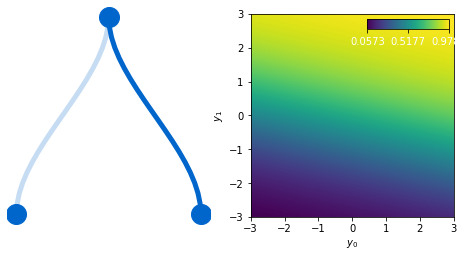

In [8]:
visualize_network(weights=[ [ 
    [0.2, 0.9]  # pesos de 2 neuronas de entrada para una neurona simple de salida
    ] ],
    biases=[ 
        [0.5] # bias para una neurona simple de salida
            ],
    activations=[ 'sigmoid' # funcion de activacion para salida
                ],
    y0range=[-3, 3], y1range=[-3, 3])

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

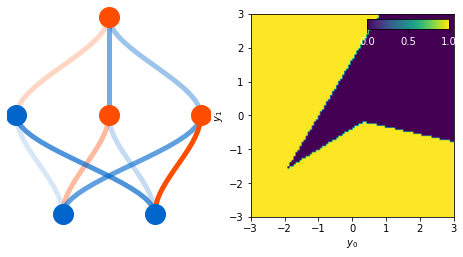

In [9]:
visualize_network(weights=[ [ 
    [0.2, 0.9],  # pesos de 2 neuronas de entrada para la priemra neurona oculta
    [-0.5, 0.3], # pesos de 2 neuronas de entrada para segunda capa oculta
    [0.8, -1.3]  # pesos de 2 neuronas de entrada para la tercera capa oculta
    ],                 
    [ 
        [-0.3, 0.7, 0.5] # pesos de 3 neuronas ocultas para la salida
    ]  ],
    biases=[ 
        [0.1, -0.5, -0.5], # biases de 3 neuronas ocultas
        [-.2] # bias para neuronas de salida
            ],
    activations=[ 'jump', # activacion para la capa oculta
                'jump' # activacion para la salida
                ],
    y0range=[-3, 3], y1range=[-3, 3])

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

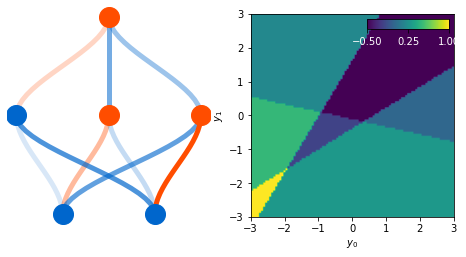

In [10]:
visualize_network(weights=[ [ 
    [0.2, 0.9],  # pesos de 2 neuronas de entrada para la priemra neurona oculta
    [-0.5, 0.3], # pesos de 2 neuronas de entrada para segunda capa oculta
    [0.8, -1.3]  # pesos de 2 neuronas de entrada para la tercera capa oculta
    ],                 
    [ 
        [-0.3, 0.7, 0.5] # pesos de 3 neuronas ocultas para la salida
    ]  ],
    biases=[ 
        [0.1, -0.5, -0.5], # biases de 3 neuronas ocultas
        [-.2] # bias para neuronas de salida
            ],
    activations=[ 'jump', # activacion para la capa oculta
                'linear' # activacion para la salida
                ],
    y0range=[-3,3],y1range=[-3,3])

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

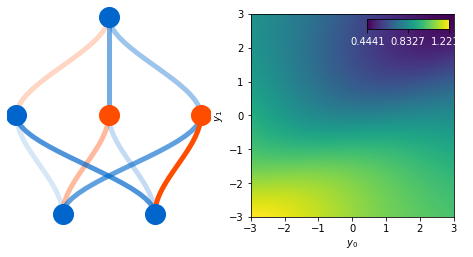

In [11]:
# lo mismo, pero con sigmoide
visualize_network(weights=[ 
    [ [0.2, 0.9],  [-0.5, 0.3], [0.8, -1.3]  ],                 
    [ [-0.3, 0.7, 0.5] ]  
    ],
    biases=[ 
        [0.1, -0.5, -0.5],
        [0.5]
    ],
    activations=[ 'sigmoid', # activacion de la capa oculta
                'linear' # activacion de la salida
                ],
    y0range=[-3,3],y1range=[-3,3])

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

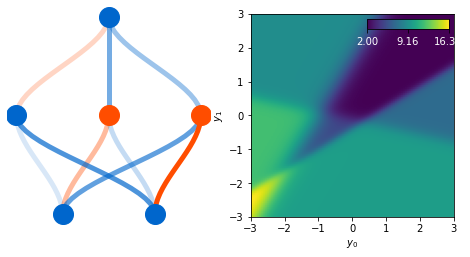

In [12]:
# sharper sigmoid: scalar todos los pesos y biases\
factor=10.0

visualize_network(weights = [ 
    factor*np.array([ [0.2, 0.9],  [-0.5, 0.3], [0.8, -1.3]  ]),                 
    factor*np.array([ [-0.3, 0.7, 0.5] ])
    ],
    biases = [ 
        factor*np.array([0.1, -0.5, -0.5]),
        factor*np.array([0.5])
    ],
    activations = [ 'sigmoid', # activacion para la capa oculta
                'linear' # activacion para la salida
                ],
    y0range = [-3, 3], y1range = [-3, 3])

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

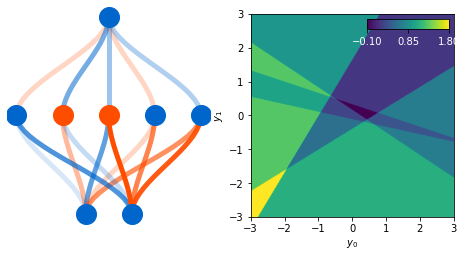

In [13]:
visualize_network(weights = [ [ [0.2, 0.9], [-0.5, 0.3], [0.8, -1.3],
                            [-0.3, -0.9], [-0.8, -1.2] ], 
                           [ [-0.3, 0.7, 0.5, -0.3, 0.4] ]  ],
                 biases = [ [0.1, -0.5, -0.5, 0.3, 0.2], [0.5] ],
                 activations = [ 'jump', 'linear' ],
                 y0range = [-3, 3], y1range = [-3, 3], M = 400)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

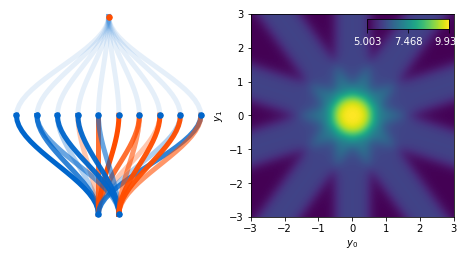

In [14]:
n_lines = 10
phi = np.linspace(0, 2*np.pi, n_lines + 1)[0:n_lines]

weight_array = np.zeros([n_lines, 2])
weight_array[:, 0] = factor*np.cos(phi)
weight_array[:, 1] = factor*np.sin(phi)
bias_array = np.full(n_lines, factor*( + 0.5))

# sharper sigmoid: scalado de los pesos y bias
factor = 20.0

visualize_network(weights = [ 
    weight_array, 
    np.full([1, n_lines], 1.0)
    ],
    biases = [ 
        bias_array,
        [0.0]
    ],
    activations = [ 'sigmoid', # activacion para la calpa oculta
                'linear' # activacion de la salida
                ],
    y0range = [-3, 3], y1range = [-3, 3],
                 size = 30.0, M = 400)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

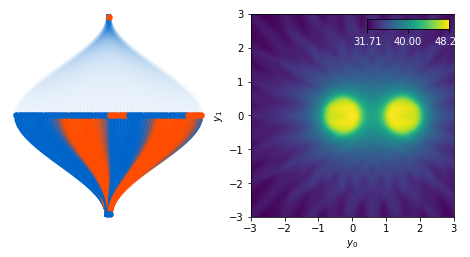

In [16]:
n_lines = 30
phi = np.linspace(0, 2*np.pi, n_lines + 1)[0:n_lines]

shifts = [-0.3, 1.5]
n_blobs = len(shifts)
full_weight_array = np.zeros([n_blobs*n_lines, 2])
full_bias_array = np.zeros(n_blobs*n_lines)

j = 0
for shift in shifts:
    weight_array = np.zeros([n_lines, 2])
    weight_array[:, 0] = factor*np.cos(phi)
    weight_array[:, 1] = factor*np.sin(phi)
    bias_array = np.full(n_lines,factor*( + 0.5 - shift*np.cos(phi)))
    full_weight_array[j*n_lines:(j + 1)*n_lines, :] = weight_array[:, :]
    full_bias_array[j*n_lines:(j + 1)*n_lines] = bias_array[:]
    j += 1

# sharper sigmoid
factor=20.0
visualize_network(weights=[ 
    full_weight_array, 
    np.full([1, n_blobs*n_lines], 1.0)
    ],
    biases = [ 
        full_bias_array,
        [0.0]
    ],
    activations = [ 'sigmoid', # activacion para la capa oculta
                'linear' # activacion para la salida
                ],
    y0range = [-3, 3], y1range = [-3, 3],
                 size = 30.0, M = 400)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


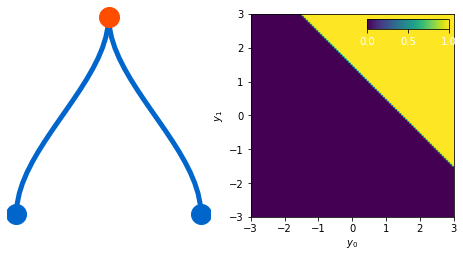

In [17]:
# La funcion AND
# esto calcula la funcion AND de las entradas,
# y1 = +1, y2 = +1 mapea a +1, pero
# las otras combinaciones (como y1 = 0, y2 = +1 etc.) todas mapea a 0

visualize_network(weights=[ [ 
    [1.0, 1.0]  # pesos para dos neuronas de entradapara una neurona simple de salida
    ] ],
    biases = [ 
        [-1.5] # bias para una neurona simple de saldia
            ],
    activations = [ 'jump' # activacion para la salida
                ],
    y0range =[-3, 3], y1range = [-3, 3])